In [1]:
import os
import re
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize

from collections import Counter  
import numpy as np
import string 
#import spacy
from nltk.stem import PorterStemmer
from collections import Counter  
from nltk.corpus import stopwords


In [2]:
#load data 

def get_data(path):
    files=os.listdir(path)
    data=[]
    for fsub in files:
        f = open(path+"/"+fsub,"r",encoding='UTF-8').read()
        data.append(f)
    return data

#path='/Users/dl/Documents/RIT related/aclImdb/train/'
#path2='/Users/dl/Documents/RIT related/aclImdb/test/'

path = "C:/Users/wangx/IMDB/train/"
path2 = "C:/Users/wangx/IMDB/test/"

train_pos=get_data(path+'pos')   # 12500  list
train_neg=get_data(path+'neg')   # 12500
train_data=train_pos+train_neg   # 25000
test_pos=get_data(path2+'pos')   # 12500  list
test_neg=get_data(path2+'neg')
test_data=test_pos+test_neg      # 25000
len(test_data)
#train_data

25000

In [3]:
# build vocab with frequency
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def vocabulary(data):
    total=[]
    ps=PorterStemmer() 
    for s in data:
        word=word_tokenize(s)
        for w in word:
            if w.lower().isalpha() and w.lower() not in stop_words:
                total.append(ps.stem(w.lower()))   

    vocab=Counter(total)
    # Removing the words that only appear once
    vocab = {k:v for k,v in vocab.items() if v>1}
    # Sorting the words according to the number of appearances, with the most common word being first
    vocab = sorted(vocab, key=vocab.get, reverse=True)
    vocab = ['_UNK'] + vocab
    word2idx = {o:i for i,o in enumerate(vocab)}
    idx2word = {i:o for i,o in enumerate(vocab)}
    return word2idx,idx2word
                
word2idx,idx2word=vocabulary(train_data)
#len(vocab)  #48448
len(word2idx)  #30202

30202

In [4]:

def data_proprocessing(data,word2idx):
    dataclean=[]
    ps=PorterStemmer() 
    for s in data:
        sen=[]
        word=word_tokenize(s)
        for w in word:
            if w.lower().isalpha() and w.lower() not in stop_words:
                sen.append(ps.stem(w.lower()))            
        
        #text_as_int = [vocab[c] for c in sen]  
        text_as_int=[word2idx[word] if word in word2idx else 0 for word in sen]
        if len(sen)>400:
            data_list=text_as_int[0:400]
        else:
            l=400-len(sen)
            data_list=[0]*l+text_as_int                  
        dataclean.append(data_list)    
    return np.array(dataclean)

In [5]:
train_x=data_proprocessing(train_data,word2idx)
test_x=data_proprocessing(test_data,word2idx)
#len(test_x)  # 25000

N=len(train_pos)
train_y=np.vstack((np.ones((N,1)),np.zeros((N,1))))
test_y=np.vstack((np.ones((N,1)),np.zeros((N,1))))
len(train_x)

25000

In [6]:
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

train_data=TensorDataset(torch.from_numpy(train_x),torch.from_numpy(train_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
batch_size =50
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [7]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device


device(type='cuda')

In [8]:
# design GRU model 
import torch.nn as nn

class GRUSentiment(nn.Module):
    def __init__(self,vocab_size, output_size, embedding_dim, hidden_dim, n_layers,drop_prob=0.2):   
        super(GRUSentiment, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        gru_out, hidden = self.gru(embeds)
        out=self.dropout(gru_out)
        
        out = self.fc(out)        
        out = out.view(batch_size, -1)
        #out = out[:,-1]  # get the last one
        out=out[:,-1].view(-1,1)
        return out

In [9]:
vocab_size =  len(word2idx) 
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 1

model1 = GRUSentiment(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model1.to(device)

lr=1e-4
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)
model1.eval()

GRUSentiment(
  (embedding): Embedding(30202, 400)
  (gru): GRU(400, 256, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [11]:
model1.train() 
for inputs, labels in train_loader:
                
        inputs, labels = inputs.to(device), labels.to(device)
        #model.zero_grad()
        optimizer.zero_grad()        
        output= model1(inputs)
        loss = criterion(output, labels)
        loss.backward()
loss

tensor(0.6582, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

torch.Size([200, 1])

In [12]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    #acc = correct.sum() / len(correct)
    acc = correct.sum()
    return acc

In [13]:
def evaluate(model1, dataset, criterion):    
    epoch_loss = 0
    epoch_acc = 0
    model1.eval()    
    N=25000
    with torch.no_grad():    
        for data, label in dataset:
            data, label = data.to(device), label.to(device)
            pred = model1(data)            
            loss = criterion(pred, label)           
            acc = binary_accuracy(pred.squeeze(), label.squeeze())
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()        
    return epoch_loss / N, epoch_acc /N

In [14]:
def fitModel(epochs,model,criterion,optimizer,train_loader,test_loader,N):
    clip =5
    trainAcc=[]
    testAcc=[]
    #model1.train()
    for i in range(epochs):
        epoch_loss = 0
        epoch_acc = 0

        test_loss=0
        test_acc=0

        model1.train() 
        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            #model.zero_grad()
            optimizer.zero_grad()        
            output= model1(inputs)
            loss = criterion(output, labels)
            loss.backward()
            acc = binary_accuracy(output.squeeze(), labels.squeeze())
            nn.utils.clip_grad_norm_(model1.parameters(), clip)
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        test_loss, test_acc =evaluate(model1, test_loader, criterion)          
        print("epoch Loss:",epoch_loss/N, "epoch Acc:",epoch_acc/N, "testloss:",test_loss, "test_acc",test_acc)
        trainAcc.append(epoch_acc/N)
        testAcc.append(test_acc)
    return trainAcc,testAcc

lr=1e-3
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)
model1.eval()
N=len(train_data)
trainAcc,testAcc=fitModel(30,model1,criterion,optimizer,train_loader,test_loader,N)

epoch Loss: 0.010110035347163713 epoch Acc: 0.75396 testloss: 0.00851616707714721 test_acc 0.81264
epoch Loss: 0.006123943786484509 epoch Acc: 0.8756 testloss: 0.00699617518677562 test_acc 0.85132
epoch Loss: 0.003884648330975434 epoch Acc: 0.92752 testloss: 0.00742989704023615 test_acc 0.84976
epoch Loss: 0.0021795739101056755 epoch Acc: 0.9632 testloss: 0.008253110048546187 test_acc 0.85856
epoch Loss: 0.0011868886907961953 epoch Acc: 0.979 testloss: 0.009741987888377119 test_acc 0.85088
epoch Loss: 0.0005742287262294822 epoch Acc: 0.99004 testloss: 0.011744406331599205 test_acc 0.85536
epoch Loss: 0.0004290051630245658 epoch Acc: 0.99356 testloss: 0.013284818412529289 test_acc 0.8558
epoch Loss: 0.0004872762547648221 epoch Acc: 0.99184 testloss: 0.013618180030265515 test_acc 0.85364
epoch Loss: 0.00025799657296335284 epoch Acc: 0.996 testloss: 0.01430205151439855 test_acc 0.8498
epoch Loss: 0.00011545907438338615 epoch Acc: 0.99852 testloss: 0.015496718770280034 test_acc 0.85528
epo

In [15]:
print(trainAcc,testAcc)

[0.75396, 0.8756, 0.92752, 0.9632, 0.979, 0.99004, 0.99356, 0.99184, 0.996, 0.99852, 0.99404, 0.99492, 0.99572, 0.99572, 0.99784, 0.9984, 0.99692, 0.99824, 0.99756, 0.99668, 0.99816, 0.99892, 0.99876, 0.99804, 0.99864, 0.99972, 0.99876, 0.99808, 0.99884, 0.99932] [0.81264, 0.85132, 0.84976, 0.85856, 0.85088, 0.85536, 0.8558, 0.85364, 0.8498, 0.85528, 0.85004, 0.84872, 0.84992, 0.84388, 0.85508, 0.85404, 0.852, 0.85244, 0.84512, 0.8498, 0.85156, 0.84944, 0.84576, 0.84956, 0.8508, 0.84612, 0.84636, 0.847, 0.85012, 0.83796]


Text(0.5, 1.0, 'GRU Test Acc Report')

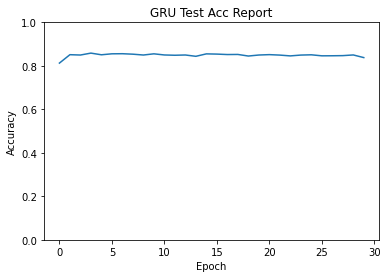

In [17]:
plt.plot(testAcc,'-')
plt.ylim([0,1])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GRU Test Acc Report")